In [202]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from numpy.linalg import inv

## Set up bandit

In [643]:
class MultiArmedBandit(gym.Env):
    def __init__(self, k, reward_std=1):
        self.reward_mean = np.random.normal(0, 1, k)
        self.reward_std = np.ones(k) * reward_std
        super().__init__()
        
    def step(self, action):
        reward = np.random.normal(self.reward_mean[action], self.reward_std[action])
        
        observation, done, info = 0, False, dict()
        return observation, reward, done, info

In [33]:
class Agent():
    def __init__(self, k):
        self.k = k
    def act(self):
        return None
    def update(self, reward):
        pass

## Epsilon Greedy

In [50]:
class EpsilonGreedy(Agent):
    def __init__(self, k, epsilon):
        self.epsilon = epsilon
        self.Q = np.random.normal(0, 1e-6, k)   # To break ties
        self.N = np.zeros(k)
        self.step = 0
        super().__init__(k)
    def act(self):
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.k)
        else:
            return np.argmax(self.Q)
    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

In [120]:
def run_exp(bandit, agent):
    actions = []
    rewards = []
    for _ in range(1000):
        action = agent.act()
        _, reward, _, _ = bandit.step(action)
        agent.update(action, reward)
        actions.append(action)
        rewards.append(reward)
    return actions, rewards

In [121]:
all_actions, all_rewards = [], []
for _ in tqdm(range(200)):
    bandit = MultiArmedBandit(10)
    agent = EpsilonGreedy(10, 0.1)
    actions, reward = run_exp(bandit, agent)
    optimal_action = np.argmax(bandit.reward_mean)
    all_actions.append(actions == optimal_action)
    all_rewards.append(reward)

  0%|          | 0/200 [00:00<?, ?it/s]

In [122]:
all_actions = np.array(all_actions)
all_rewards = np.array(all_rewards)
all_actions.shape

(200, 1000)

In [123]:
optimal_percentage = all_actions.mean(0)
mean_reward = all_rewards.mean(0)

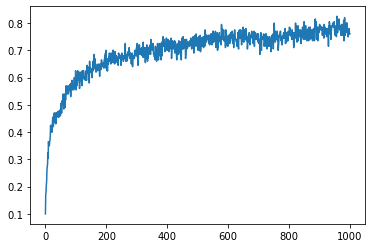

In [124]:
plt.plot(optimal_percentage)

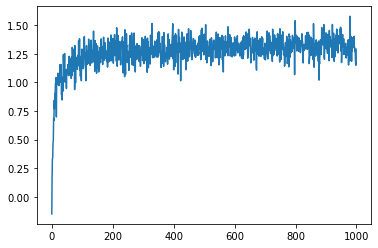

In [125]:
plt.plot(mean_reward)

## Policy Gradient

In [452]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum()

In [453]:
class PolicyGradient(Agent):
    def __init__(self, k, alpha=0.25):
        self.alpha = alpha
        self.H = np.random.normal(0, 1e-3, k)   # To break ties
        self.R_mean = 0
        self.step = 0
        super().__init__(k)
    def act(self):
        self.probs = softmax(self.H)
        action = np.random.choice(self.k, p=self.probs)
        return action
    def update(self, action, reward):
        action_one_hot = np.zeros(self.k)
        action_one_hot[action] = 1
        self.H += self.alpha * (reward - self.R_mean) * (action_one_hot - self.probs)
        
        self.step += 1
        self.R_mean += (reward - self.R_mean) / self.step

In [454]:
all_actions, all_rewards = [], []
for _ in tqdm(range(200)):
    bandit = MultiArmedBandit(10)
    agent = PolicyGradient(10)
    actions, reward = run_exp(bandit, agent)
    optimal_action = np.argmax(bandit.reward_mean)
    all_actions.append(actions == optimal_action)
    all_rewards.append(reward)

  0%|          | 0/200 [00:00<?, ?it/s]

In [455]:
all_actions = np.array(all_actions)
all_rewards = np.array(all_rewards)
all_actions.shape

(200, 1000)

In [456]:
optimal_percentage = all_actions.mean(0)
mean_reward = all_rewards.mean(0)

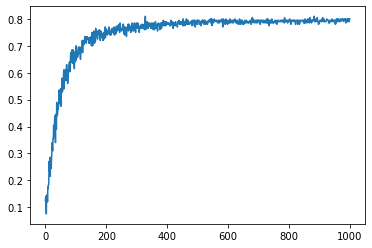

In [457]:
plt.plot(optimal_percentage)

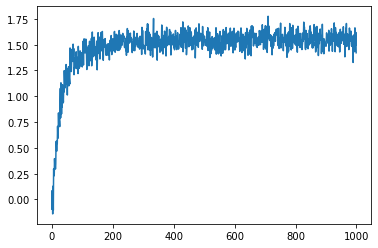

In [458]:
plt.plot(mean_reward)

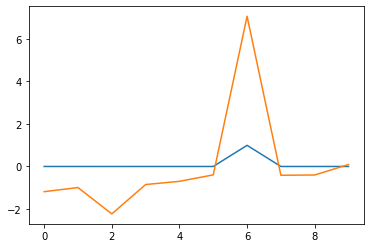

In [461]:
plt.plot(agent.probs)
plt.plot(agent.H)

## EnKI

In [897]:
def softmax_ens(x):
    return np.exp(x) / np.exp(x).sum(0)

In [1072]:
class EnKI(Agent):
    def __init__(self, k, N_ens, obs_noise=1e-3, ic_noise=1e-3, update_noise=1e-3, inflation=1):
        self.H_ens = np.random.normal(0, ic_noise, (k, N_ens))
        self.H = np.zeros(k)
        self.N_ens = N_ens
        self.R = np.diag(np.ones(1) * obs_noise)
        self.H_hist = [self.H]
        self.H_ens_hist = [self.H_ens]
        self.update_noise = update_noise
        self.inflation = inflation
        super().__init__(k)
        
    def act(self):
        H_cat = np.concatenate([self.H[:, None], self.H_ens], axis=1)
        self.probs = softmax_ens(H_cat)
        actions = np.array([np.random.choice(self.k, p=self.probs[:, i]) for i in range(self.N_ens + 1)])
        return actions
    
    def update(self, rewards):
        reward = rewards[0]
        reward_ens = rewards[1:]
        # import pdb; pdb.set_trace()
        x_f = self.H
        x_f_ens = self.H_ens  # n x N_ens

        hx_f = -reward[None]
        hx_f_ens = -reward_ens[None, :]  # m x N_ens
        
        X = x_f_ens - x_f_ens.mean(1)[:, None]
        Y = hx_f_ens - hx_f_ens.mean(1)[:, None]
        K = X @ Y.T @ inv(Y @ Y.T + (self.N_ens - 1) * self.R) # Potential error here
        
        # x_a = x_f - K @ hx_f
        # x_a_ens = x_f_ens - K @ hx_f_ens
        x_a = x_f - K.squeeze()
        x_a_ens = x_f_ens - K

        
        self.H = x_a
        self.H_ens = x_a_ens
        self.H_mean = self.H_ens.mean(1)
        self.H_ens_hist.append(self.H_ens)


In [1138]:
def run_exp_ens(bandit, agent, iterations=1000, iterations_per_step=100):
    actions = []
    rewards = []
    for _ in range(iterations):
        reward_ens = np.zeros(agent.N_ens + 1)
        for _ in range(iterations_per_step):
            action_ens = agent.act()
            for i in range(agent.N_ens + 1):
                _, r, _, _ = bandit.step(action_ens[i])
                reward_ens[i] += r        
        agent.update(reward_ens)
        actions.append(action_ens)
        rewards.append(reward_ens)
    actions = np.array(actions)
    rewards = np.array(rewards)
    return actions, rewards

In [1360]:
bandit = MultiArmedBandit(10, reward_std=1)
agent = EnKI(10, 20, ic_noise=1, obs_noise=0.2)
optimal_action = np.argmax(bandit.reward_mean)

In [1361]:
bandit.reward_mean

array([ 0.87225731, -0.43932891,  0.9436236 , -0.00845398, -0.99097582,
       -0.02715413, -0.29500115,  1.06923841, -1.27992567,  1.77859672])

In [1362]:
bandit.reward_mean.mean()

0.16228763918024774

In [1363]:
optimal_action

9

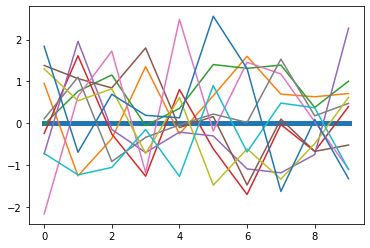

In [1364]:
plt.plot(agent.H, lw=5)
for i in range(10):
    plt.plot(agent.H_ens[:, i])

In [1365]:
actions, rewards = run_exp_ens(bandit, agent, iterations=1000, iterations_per_step=1)

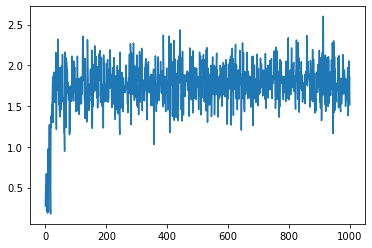

In [1366]:
plt.plot(rewards.mean(1))

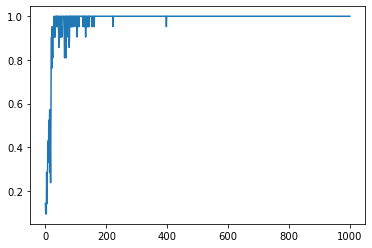

In [1367]:
plt.plot((actions == optimal_action).mean(1))

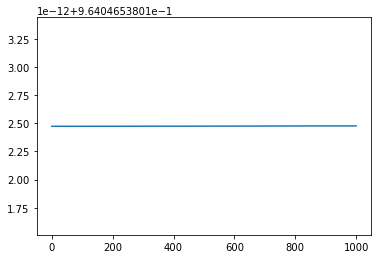

In [1368]:
plt.plot(np.array(agent.H_ens_hist).std(-1).mean(-1))

In [1369]:
np.array(agent.H_ens_hist)[0, 0].std()

0.9134364399375627

In [1370]:
np.array(agent.H_ens_hist)[1, 0].std()

0.9134364399375627

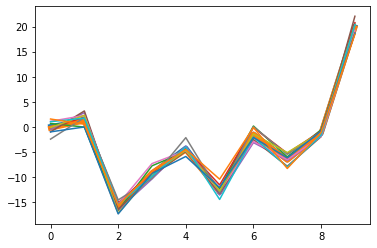

In [1371]:
plt.plot(agent.H_mean, lw=5)
plt.plot(agent.H, lw=5)
for i in range(10):
    plt.plot(agent.H_ens[:, i])

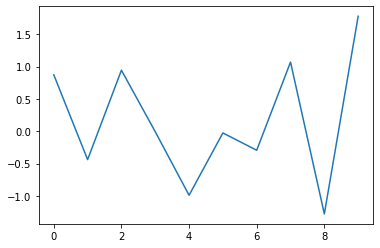

In [1372]:
plt.plot(bandit.reward_mean)

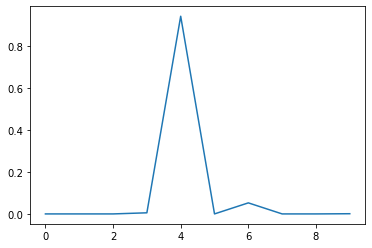

In [1359]:
plt.plot(agent.probs.mean(1));

In [121]:
all_actions, all_rewards = [], []
for _ in tqdm(range(200)):
    bandit = MultiArmedBandit(10)
    agent = EpsilonGreedy(10, 0.1)
    actions, reward = run_exp(bandit, agent)
    optimal_action = np.argmax(bandit.reward_mean)
    all_actions.append(actions == optimal_action)
    all_rewards.append(reward)

  0%|          | 0/200 [00:00<?, ?it/s]

In [122]:
all_actions = np.array(all_actions)
all_rewards = np.array(all_rewards)
all_actions.shape

(200, 1000)